<a href="https://colab.research.google.com/github/Rishi-128/ml4sci-contrastive-anomaly-dqm/blob/main/02_contrastive_pretraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive Pretraining for Detector Representations

In this notebook, we train a self-supervised contrastive encoder on augmented detector data.
The model learns representations that are invariant to small perturbations in detector conditions,
which can later be used for anomaly detection without explicit labels.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
# Synthetic detector data
X = np.random.normal(0, 1, size=(5000, 10))
X = torch.tensor(X, dtype=torch.float32)

def augment_noise(x, noise_std=0.1):
    return x + noise_std * torch.randn_like(x)

def augment_scaling(x, scale_range=(0.9, 1.1)):
    scale = torch.empty(x.size(0), 1).uniform_(*scale_range)
    return x * scale


In [3]:
class ContrastiveEncoder(nn.Module):
    def __init__(self, input_dim=10, latent_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, x):
        z = self.net(x)
        return nn.functional.normalize(z, dim=1)


In [4]:
model = ContrastiveEncoder().to(device)


In [5]:
def contrastive_loss(z1, z2, temperature=0.5):
    batch_size = z1.size(0)
    z = torch.cat([z1, z2], dim=0)

    similarity = torch.matmul(z, z.T) / temperature
    mask = torch.eye(2 * batch_size, device=z.device).bool()
    similarity.masked_fill_(mask, -9e15)

    labels = torch.cat([
        torch.arange(batch_size, 2*batch_size),
        torch.arange(0, batch_size)
    ]).to(z.device)

    return nn.CrossEntropyLoss()(similarity, labels)


In [6]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
batch_size = 128

losses = []

for epoch in range(epochs):
    perm = torch.randperm(len(X))
    epoch_loss = 0

    for i in range(0, len(X), batch_size):
        idx = perm[i:i+batch_size]
        x = X[idx].to(device)

        x1 = augment_noise(x)
        x2 = augment_scaling(x)

        z1 = model(x1)
        z2 = model(x2)

        loss = contrastive_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / (len(X) / batch_size)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")


Epoch 1/20 - Loss: 3.9662
Epoch 2/20 - Loss: 3.7830
Epoch 3/20 - Loss: 3.7646
Epoch 4/20 - Loss: 3.7559
Epoch 5/20 - Loss: 3.7415
Epoch 6/20 - Loss: 3.7330
Epoch 7/20 - Loss: 3.7245
Epoch 8/20 - Loss: 3.7244
Epoch 9/20 - Loss: 3.7126
Epoch 10/20 - Loss: 3.7136
Epoch 11/20 - Loss: 3.7131
Epoch 12/20 - Loss: 3.7063
Epoch 13/20 - Loss: 3.7040
Epoch 14/20 - Loss: 3.7047
Epoch 15/20 - Loss: 3.7009
Epoch 16/20 - Loss: 3.7009
Epoch 17/20 - Loss: 3.7003
Epoch 18/20 - Loss: 3.7008
Epoch 19/20 - Loss: 3.7000
Epoch 20/20 - Loss: 3.6999


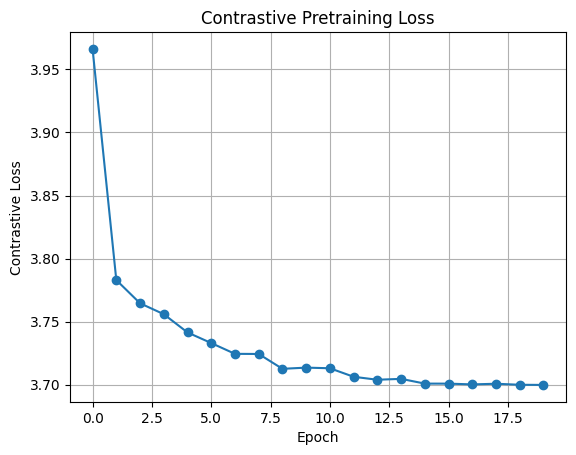

In [7]:
plt.plot(losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Contrastive Loss")
plt.title("Contrastive Pretraining Loss")
plt.grid(True)
plt.show()


In [8]:
torch.save(model.state_dict(), "contrastive_encoder.pth")


In [9]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
MODEL_DIR = "/content/drive/MyDrive/ml4sci_models"
import os
os.makedirs(MODEL_DIR, exist_ok=True)


In [12]:
torch.save(model.state_dict(), f"{MODEL_DIR}/contrastive_encoder.pth")